Assignment 2
-----------

Previously in 1_notmnist.ipynb, we created a pickle with formatted datasets for training, development and testing on the notMNIST dataset.

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in 1_notmnist.ipynb.

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)



Reformat into a shape that's more adapted to the models we're going to train:
 * data as a flat matrix,
 * labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:

 * First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:
 
      with graph.as_default():
         ...
         
 * Then you can run the operations on this graph as many times as you want by calling session.run(), providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:
 
      with tf.Session(graph=graph) as session:
         ...
         
Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [7]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():
    
    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [10]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
            predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 15.910759
Training accuracy: 7.7%
Validation accuracy: 10.9%
Loss at step 100: 2.368722
Training accuracy: 71.3%
Validation accuracy: 70.3%
Loss at step 200: 1.894782
Training accuracy: 74.2%
Validation accuracy: 73.0%
Loss at step 300: 1.637956
Training accuracy: 75.5%
Validation accuracy: 73.8%
Loss at step 400: 1.468781
Training accuracy: 76.5%
Validation accuracy: 74.3%
Loss at step 500: 1.346151
Training accuracy: 77.0%
Validation accuracy: 74.5%
Loss at step 600: 1.250986
Training accuracy: 77.7%
Validation accuracy: 74.8%
Loss at step 700: 1.174138
Training accuracy: 78.3%
Validation accuracy: 75.0%
Loss at step 800: 1.110303
Training accuracy: 78.8%
Validation accuracy: 75.1%
Test accuracy: 82.5%


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of session.run().

In [11]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [13]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 18.713032
Minibatch accuracy: 12.5%
Validation accuracy: 11.5%
Minibatch loss at step 500: 1.384217
Minibatch accuracy: 75.8%
Validation accuracy: 74.4%
Minibatch loss at step 1000: 1.444064
Minibatch accuracy: 74.2%
Validation accuracy: 75.8%
Minibatch loss at step 1500: 1.612222
Minibatch accuracy: 76.6%
Validation accuracy: 76.8%
Minibatch loss at step 2000: 1.080111
Minibatch accuracy: 82.0%
Validation accuracy: 77.0%
Minibatch loss at step 2500: 1.191528
Minibatch accuracy: 74.2%
Validation accuracy: 77.2%
Minibatch loss at step 3000: 1.019006
Minibatch accuracy: 78.9%
Validation accuracy: 77.5%
Test accuracy: 84.6%


Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. 

This model should improve your validation / test accuracy.

In [25]:
hidden_size = 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables
    # This is the first change to the above code. Since each node in the hidden layer have it's own 
    # inputs and biases, we have to define:
    
    # Input weights for the hidden layer, each node (out of 1024) will get 784 initial values:
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    print('Shape of W1 is', W1.shape)
    
    # 1024 Bias terms for the hidden layers, one for each node
    b1 = tf.Variable(tf.zeros([hidden_size]))
    print('Shape of b1 is', b1.shape)
    
    # Input weights for the final layer. Each node (out of 10 classes) will get 1024 inputs.
    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    print('Shape of W2 is', W2.shape)
    
    # One bias term for each of the 10 output classes
    b2 = tf.Variable(tf.zeros([num_labels]))
    print('Shape of b2 is', b2.shape)
    
    # Training computation. 
    # The computation is much bigger now.
    # 1) Calculate the regular linear regression (Wx + b) to the data coming from the input layer
    # 2) Apply relu on the result
    # 3) Calculate the regular linear regression again to the data coming out of the input layer
    logits = tf.matmul(tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1), W2) + b2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1), W2) + b2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1), W2) + b2)



Shape of W1 is (784, 1024)
Shape of b1 is (1024,)
Shape of W2 is (1024, 10)
Shape of b2 is (10,)


Run the code again, nothing really changed below:

In [30]:
num_steps = 3001
print('Train dataset size is ', train_dataset.shape)
print('Valid dataset size is ', valid_dataset.shape)
print('Test dataset size is ', test_dataset.shape)

plot_data = np.zeros((60, 4))

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            mini_accuracy = accuracy(predictions, batch_labels)
            print("Minibatch accuracy: %.1f%%" % mini_accuracy)
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            print("Validation accuracy: %.1f%%" % valid_accuracy)
            plot_data[int(step/50)] = [step/50, mini_accuracy, valid_accuracy, l]
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print("Total number of steps: %d" % step)

Train dataset size is  (200000, 784)
Valid dataset size is  (10000, 784)
Test dataset size is  (10000, 784)
Initialized
Minibatch loss at step 0: 333.563599
Minibatch accuracy: 9.4%
Validation accuracy: 22.3%
Minibatch loss at step 50: 102.042328
Minibatch accuracy: 77.3%
Validation accuracy: 73.5%
Minibatch loss at step 100: 65.967201
Minibatch accuracy: 74.2%
Validation accuracy: 75.6%
Minibatch loss at step 150: 26.107578
Minibatch accuracy: 69.5%
Validation accuracy: 76.9%
Minibatch loss at step 200: 44.888458
Minibatch accuracy: 68.8%
Validation accuracy: 74.0%
Minibatch loss at step 250: 25.516567
Minibatch accuracy: 72.7%
Validation accuracy: 79.7%
Minibatch loss at step 300: 22.878422
Minibatch accuracy: 82.8%
Validation accuracy: 77.6%
Minibatch loss at step 350: 18.820595
Minibatch accuracy: 81.2%
Validation accuracy: 80.0%
Minibatch loss at step 400: 17.993578
Minibatch accuracy: 75.8%
Validation accuracy: 80.8%
Minibatch loss at step 450: 7.035535
Minibatch accuracy: 85.2%


IndexError: index 60 is out of bounds for axis 0 with size 60

Let's plot how accuracy and cost changes as we go over the training set:

<function matplotlib.pyplot.show>

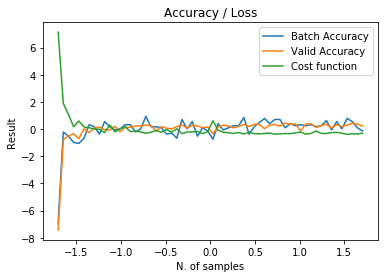

In [62]:
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
plot_data = sc.fit_transform(plot_data)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(plot_data[0:60,0], plot_data[0:60, 1], label = 'Batch Accuracy')
ax.plot(plot_data[0:60,0], plot_data[0:60, 2], label = 'Valid Accuracy')
ax.plot(plot_data[0:60,0], plot_data[0:60, 3], label = 'Cost function')
plt.title('Accuracy / Loss')
plt.xlabel('N. of samples')
plt.ylabel('Result')
plt.legend()
plt.show